In [37]:
import phoebe 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  

logger = phoebe.logger(clevel = 'WARNING')

In [38]:
phoebe.update_all_passbands()

In [39]:
b = phoebe.open('/Users/karan/Documents/GitHub/Eclipsing-Binary-Modeling/bundles/after_de_rv.bundle')

In [40]:
pblums_scaled = b.compute_pblums(compute='physics_comp', model='nm_lc_model')

print(pblums_scaled)

{'pblum@primary@rv01': <Quantity 3.9838829e+26 W>, 'pblum@secondary@rv01': <Quantity 1.94706733e+26 W>, 'pblum@primary@lc01': <Quantity 6.86331509 W>, 'pblum@secondary@lc01': <Quantity 3.58929278 W>}


In [41]:
b.set_value_all('pblum_mode', 'component-coupled')

In [42]:
b.set_value('pblum@primary@lc01', value = pblums_scaled['pblum@primary@lc01'])

print(b.compute_pblums(compute='physics_comp', dataset='lc01', pbflux=True))

{'pblum@primary@lc01': <Quantity 6.86331509 W>, 'pblum@secondary@lc01': <Quantity 3.58929278 W>, 'pbflux@lc01': <Quantity 0.83179211 W / m2>}


In [43]:
print(b['t0_supconj'])
print(b['t0@system'])
b['t0@system'] = b.get_value('t0_supconj')

Parameter: t0_supconj@binary@component
                       Qualifier: t0_supconj
                     Description: Zeropoint date at superior conjunction of the primary component
                           Value: 55749.81179087607 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, compute_times@lc01@dataset, compute_times@rv01@dataset
                      Related to: period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0@system, t0_perpass@binary@component, t0_ref@binary@component, compute_phases@lc01@dataset, phases_period@lc01@dataset, period_anom@binary@component, phases_dpdt@lc01@dataset, phases_t0@lc01@dataset, compute_times@lc01@dataset, compute_phases@rv01@dataset, phases_period@rv01@dataset, phases_dpdt@rv01@dataset, phases_t0@rv01@dataset, compute_times@rv01@dataset

Parameter: t0@system
                       Qualifier: t0
           

In [44]:
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => -85.64964493890238 deg>

In [45]:
b.flip_constraint('compute_times@rv01', solve_for='compute_phases')

<ConstraintParameter: {compute_phases@rv01@dataset} = times_to_phases({compute_times@rv01@dataset}, {phases_period@rv01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@rv01@dataset}, {dpdt@binary@component}, {phases_t0@rv01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component}) (solar units) => [ 0.00000000e+00  1.66666667e-02  3.33333333e-02  5.00000000e-02
  6.66666667e-02  8.33333333e-02  1.00000000e-01  1.16666667e-01
  1.33333333e-01  1.50000000e-01  1.66666667e-01  1.83333333e-01
  2.00000000e-01  2.16666667e-01  2.33333333e-01  2.50000000e-01
  2.66666667e-01  2.83333333e-01  3.00000000e-01  3.16666667e-01
  3.33333333e-01  3.50000000e-01  3.66666667e-01  3.83333333e-01
  4.00000000e-01  4.16666667e-01  4.33333333e-01  4.50000000e-01
  4.66666667e-01  4.83333333e-01 -5.00000000e-01 -4.83333333e-01
 -4.66666667e-01 -4.50000000e-01 -4.33333333e-01 -4.16666667e-01
 -4.00000000e-01 -3.83333333e-01 -3.66666

In [46]:
rv_times = b.get_value('times@secondary@rv01@dataset')

print(rv_times)

[55763.657622 55797.798841 55801.772678 55840.667652 55844.647447
 55860.612849 55811.613101 55840.593371 55851.578556]


In [47]:
b.set_value('compute_times@rv01', value = phoebe.linspace(rv_times[0], rv_times[-1], 501))

In [48]:
b.set_value('l3_mode', 'fraction')

In [49]:
b.add_distribution({'teffratio': phoebe.gaussian_around(0.02), 
                    'teff@primary': phoebe.gaussian_around(20), 
                    'requivsumfrac': phoebe.gaussian_around(0.01), 
                    'requivratio': phoebe.gaussian_around(0.01), 
                    'incl@binary': phoebe.uniform_around(0.05), 
                    'pblum@primary': phoebe.gaussian_around(0.01)}, distribution = 'init_sample')

b.add_distribution({'vgamma@system': phoebe.gaussian_around(0.5), 
                    'q': phoebe.gaussian_around(0.02), 
                    'asini@binary': phoebe.gaussian_around(0.1), 
                    'esinw': phoebe.uniform_around(0.01),
                    'ecosw': phoebe.uniform_around(0.01),}, distribution = 'init_sample')
 
b.add_distribution('l3_frac', phoebe.uniform(0, 0.01), distribution = 'init_sample')

<ParameterSet: 1 parameters>

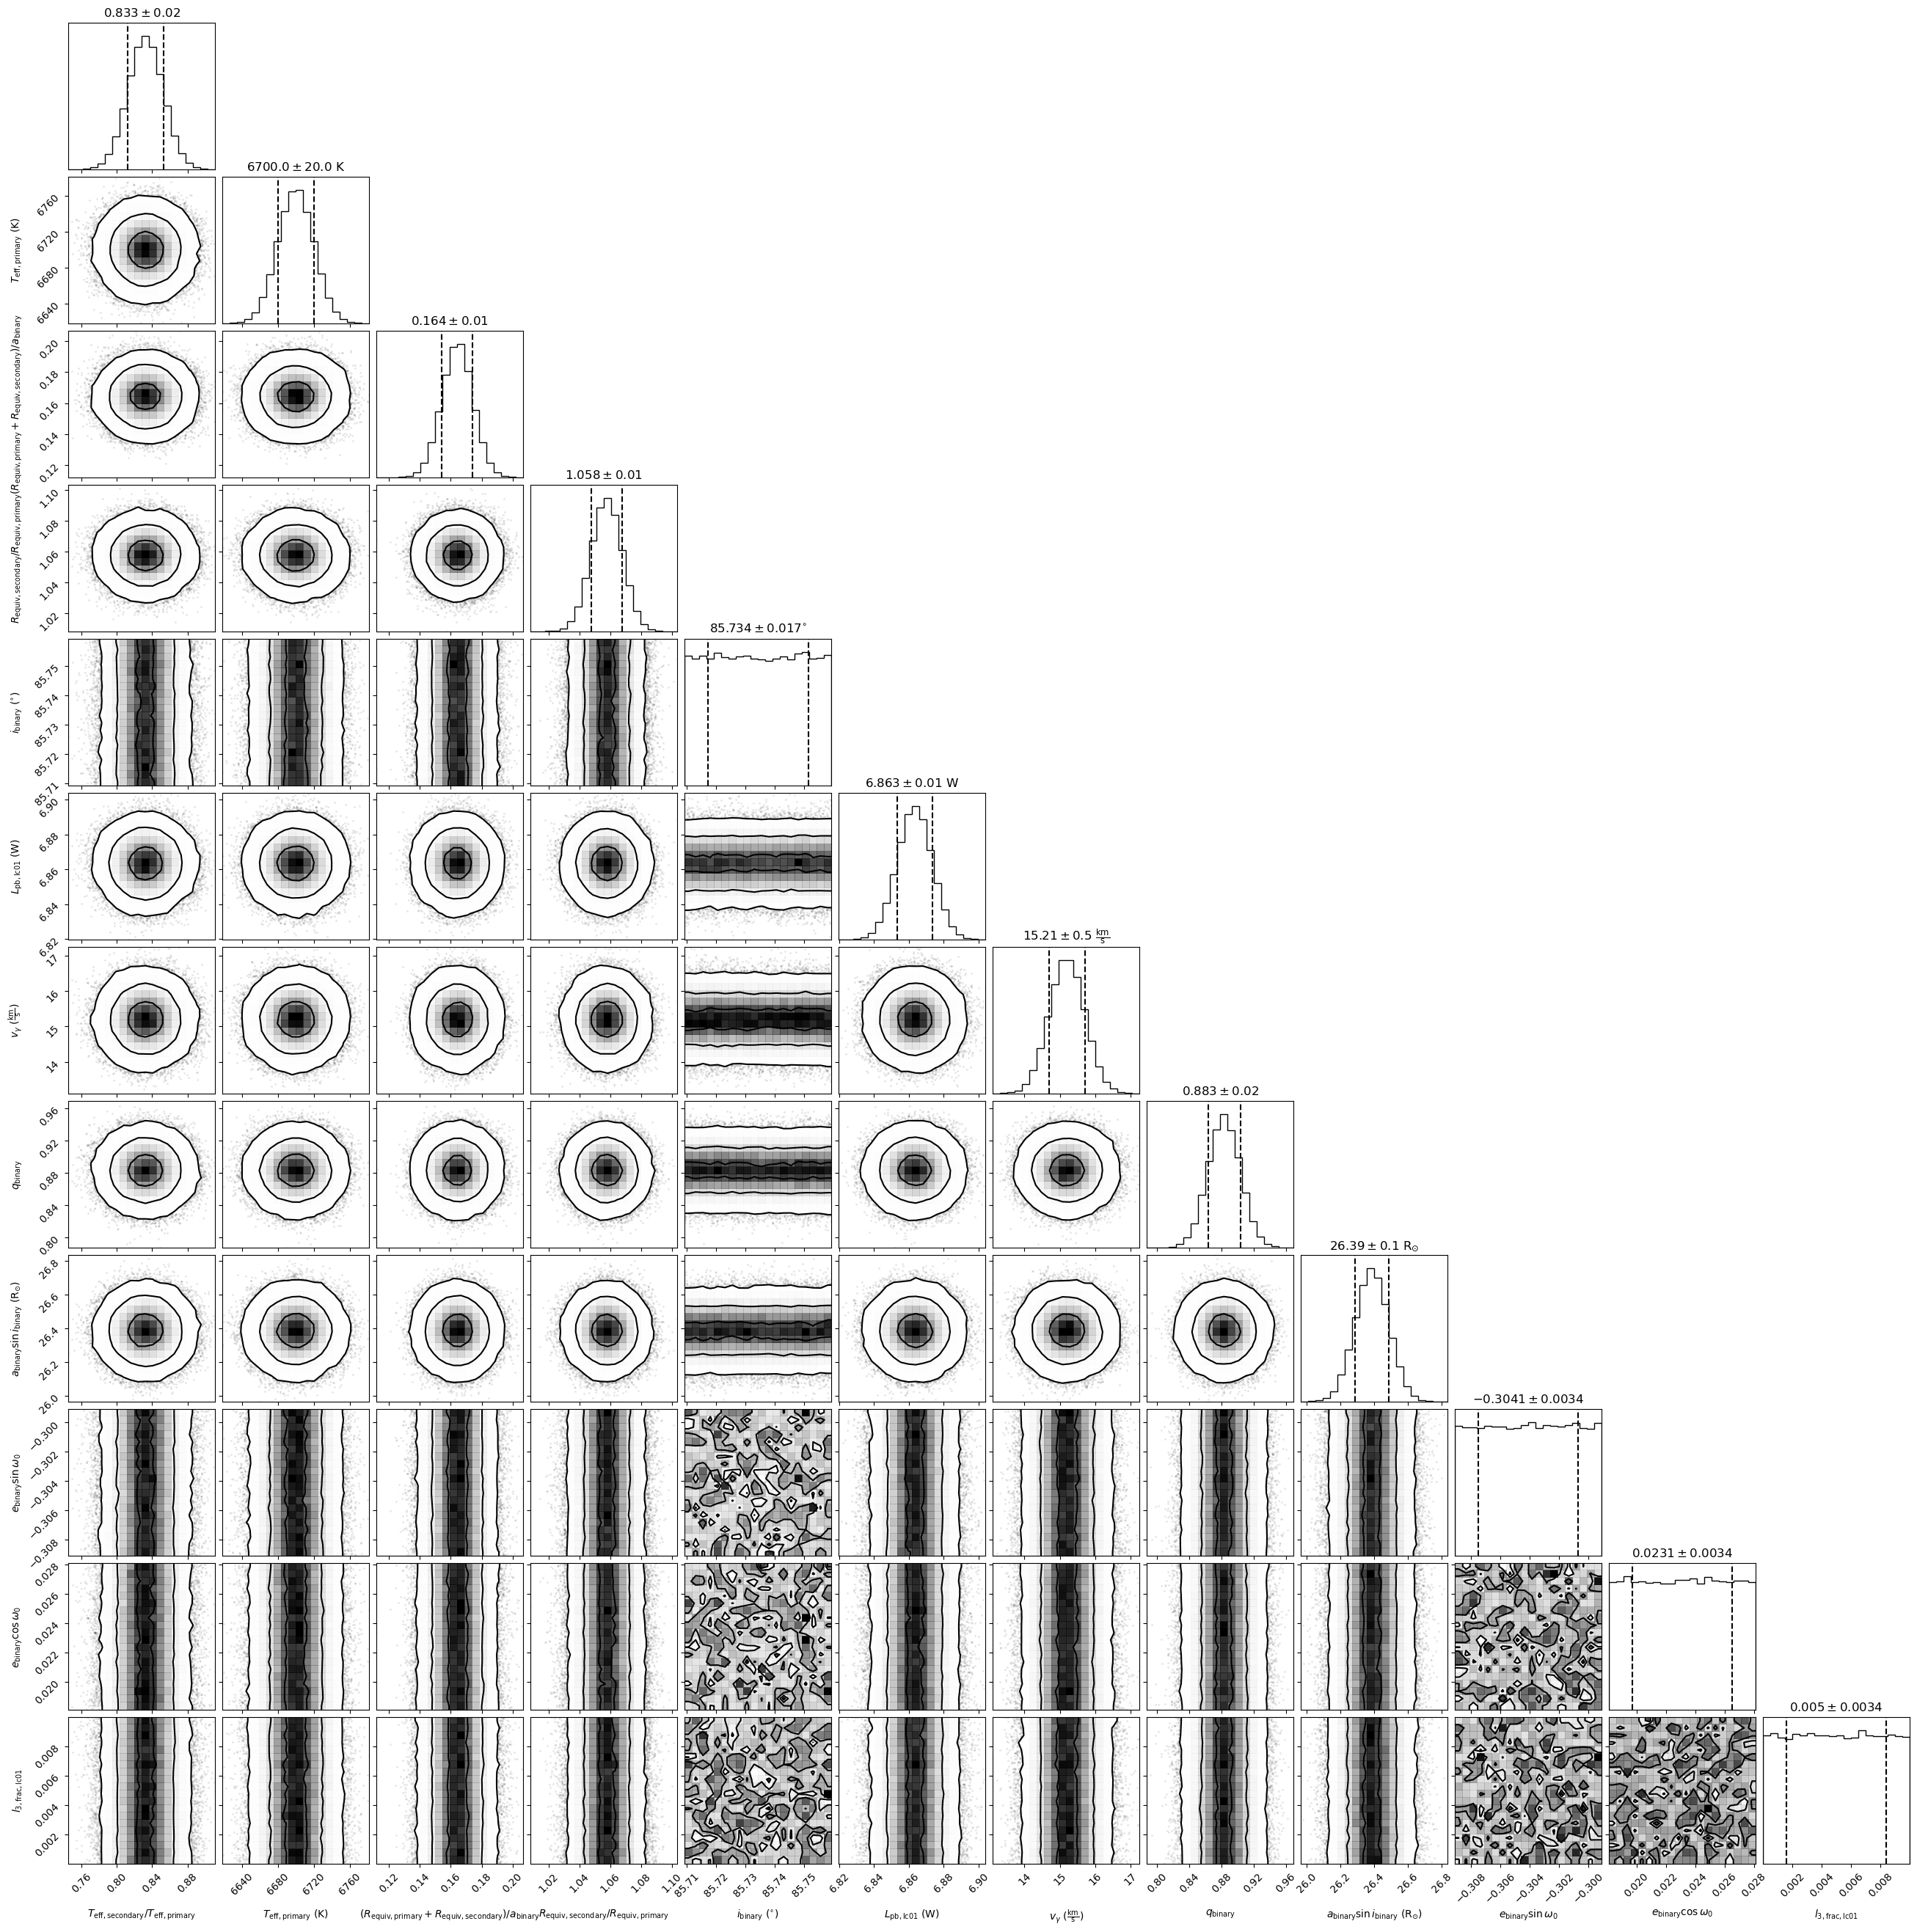

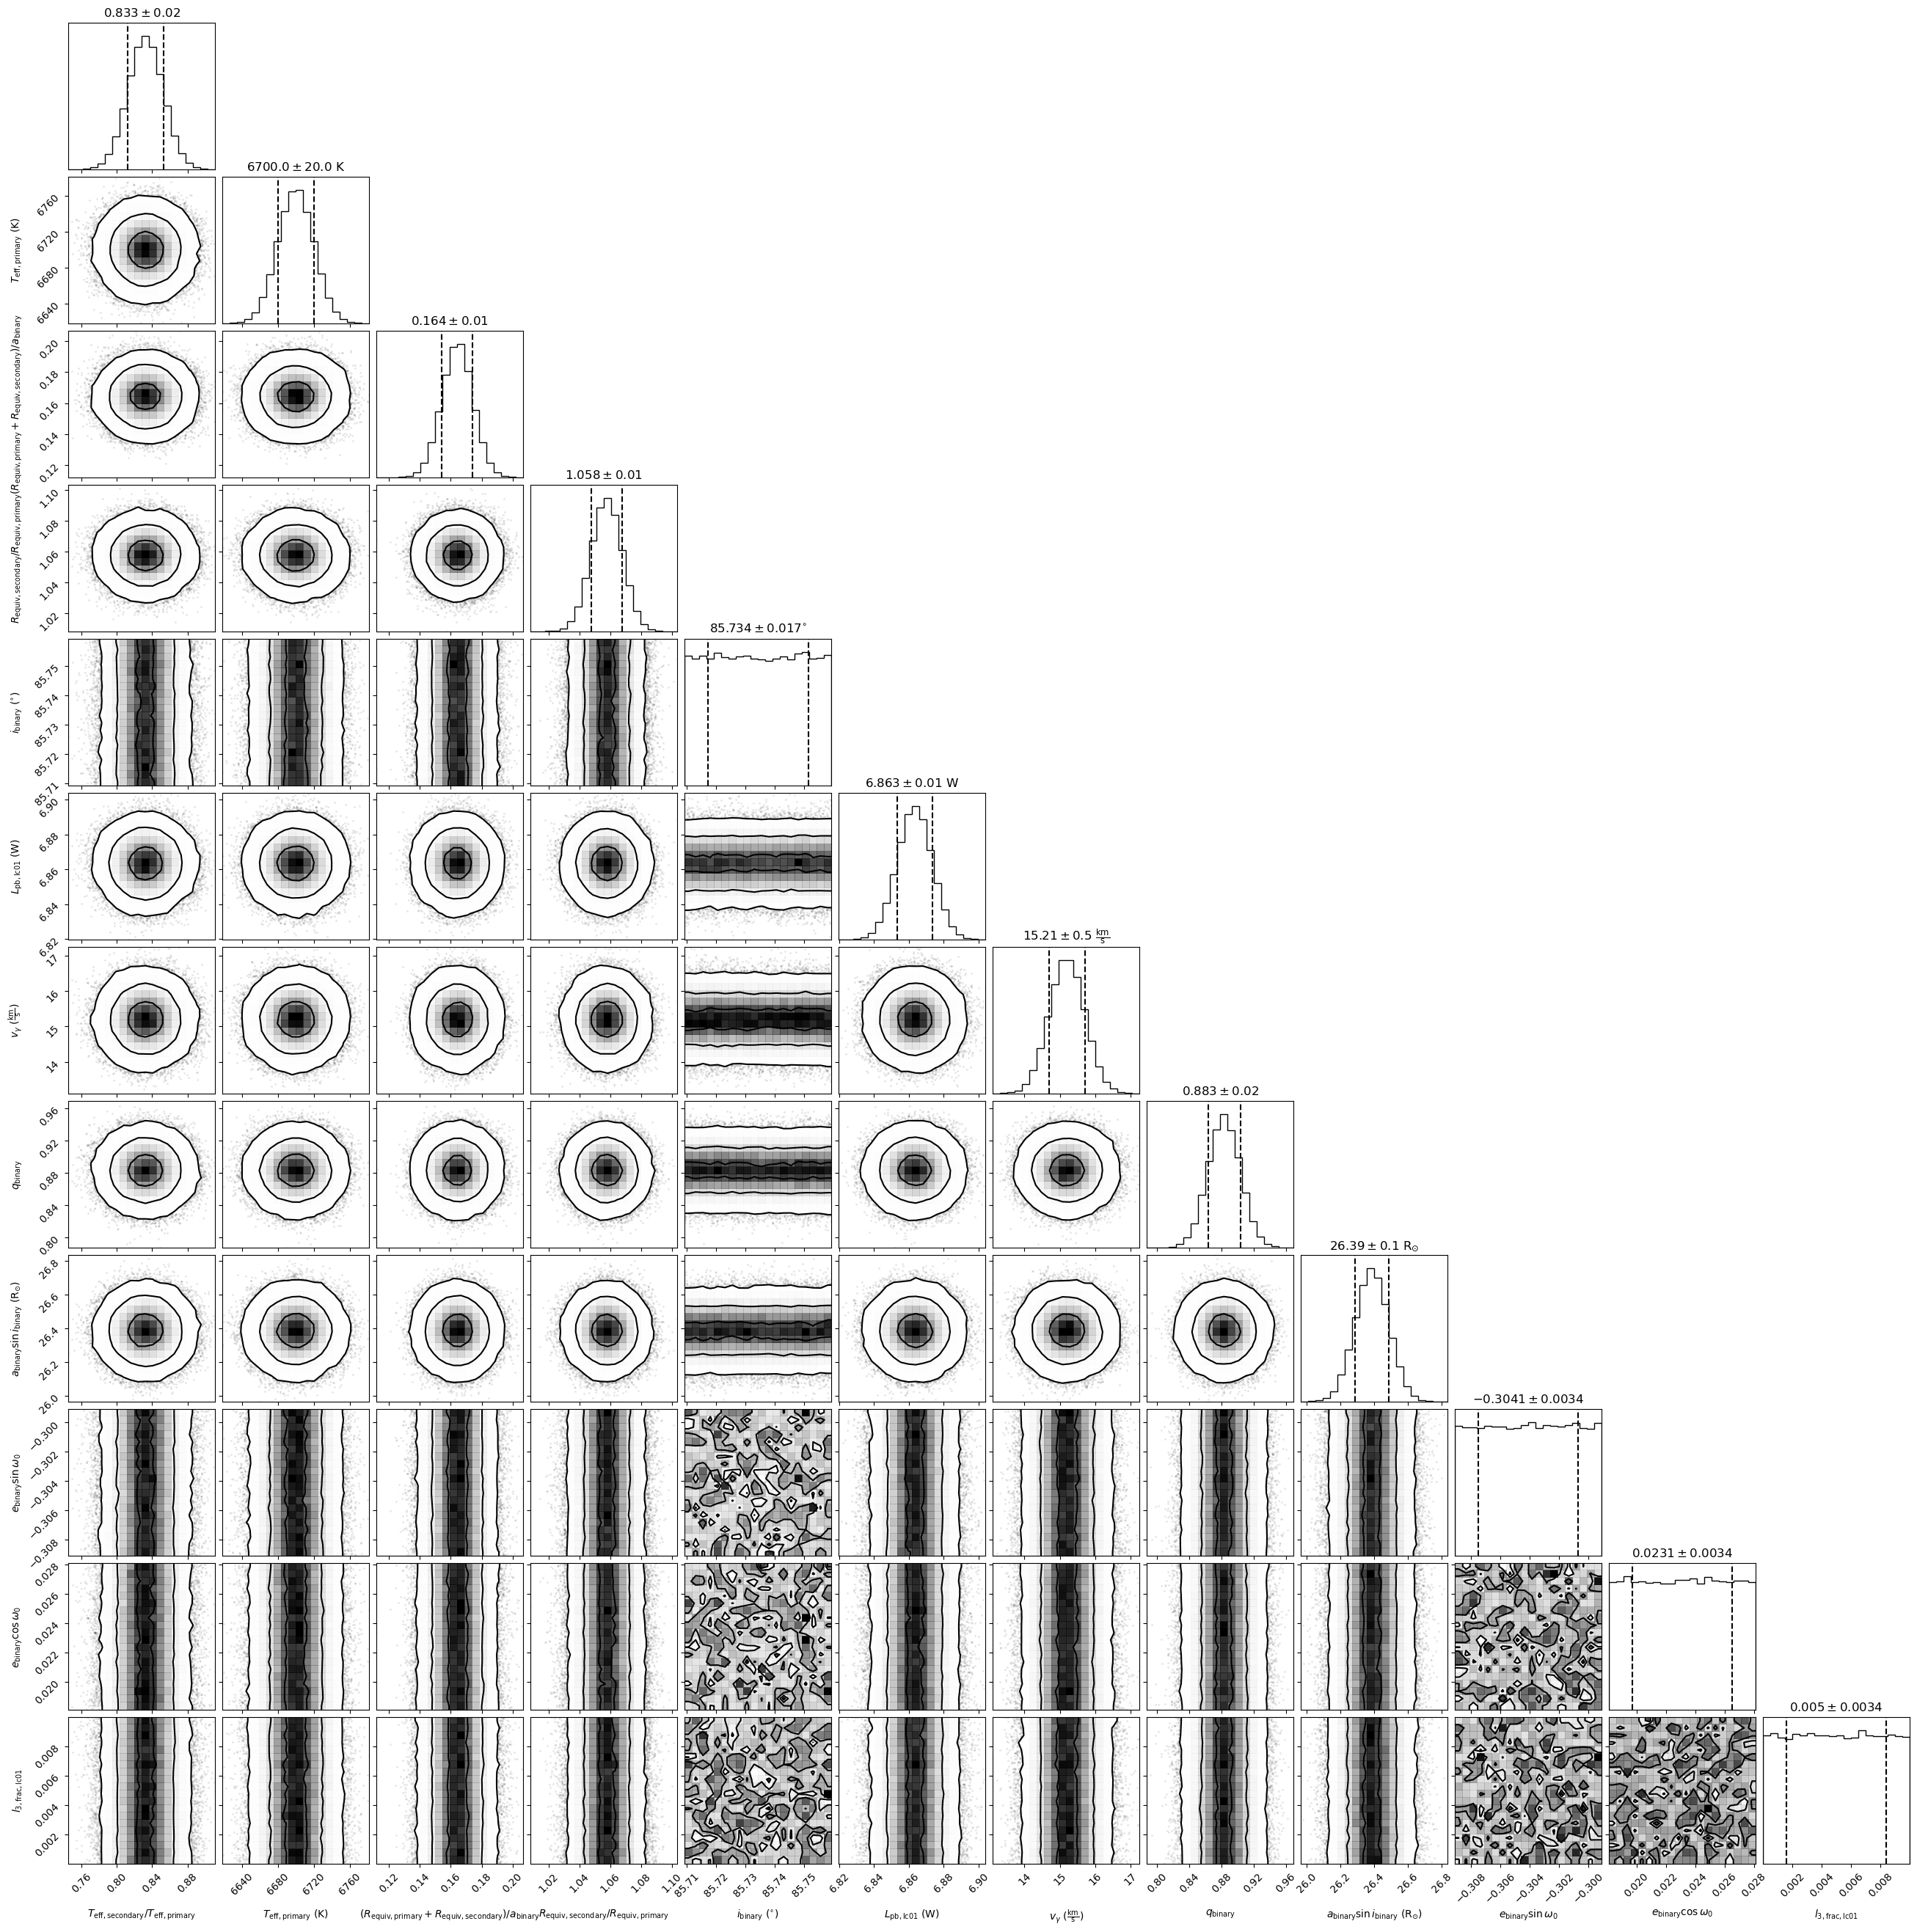

In [50]:
b.plot_distribution_collection('init_sample', show = True)

In [51]:
b.add_solver('sampler.emcee', solver = 'mcmc',
              init_from = 'init_sample',
              compute = 'physics_comp', niters = 100)

<ParameterSet: 17 parameters | qualifiers: use_server, compute, comments, progress_every_niters, nlags_factor, priors, priors_combine, nwalkers, continue_from, init_from, init_from_combine, expose_failed, init_from_requires, continue_from_iter, burnin_factor, thin_factor, niters>

In [52]:
b.set_value('nwalkers@mcmc', value = 24)

In [53]:
b.run_solver('mcmc', solution = 'init_sampling')

In [54]:
b.plot(solution = 'init_sampling', style = 'lnprobability', burnin = 0, thin = 1, show = True)

In [55]:
b.plot(solution = 'init_sampling', style = 'lnprobability', burnin = 50, thin = 1, show = True)

In [56]:
b.plot(solution = 'init_sampling', style = 'corner', burnin = 0, thin = 1, show = True)

In [57]:
b.save('after_init_sampling.bundle')